# Imports, configs, etc

In [1]:
import numpy as np
import pandas as pd
import datetime
import pvlib

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import os, sys
lib_path = os.path.abspath(os.path.join('..', 'rdtools'))
sys.path.append(lib_path)
import filtering

# Load/merge weather and performance data

Weather and performance data are taken at 1min intervals.  Supplier is the Sandia National Lab Regional Test Center in Albuquerque, NM.  Data spans roughly 2016-April 2017.  This data was scraped from PVDAQ (http://bit.ly/2mKrOwG).  The meteorological data and the performance data are contained in two separate files (technically separate systems - PV system and meteorological station).

In [2]:
nm_file = os.path.expanduser('~/data_sets/snl_raw_data/1429_1405/raw_1405_weather_for_1429.csv')
vt_file = os.path.expanduser('~/data_sets/snl_raw_data/1422_1424/raw_1424.csv')
fl_file = os.path.expanduser('~/data_sets/snl_raw_data/1403_1389/raw_1389.csv')
nv_file = os.path.expanduser('~/data_sets/snl_raw_data/1423_1425/raw_1425.csv')

In [3]:
usecols = ['Diffuse_Wm2', 'Direct_Wm2', 'Global_Wm2', 'Date-Time']

In [4]:
nm_data = pd.read_csv(nm_file, parse_dates=['Date-Time'], usecols=usecols, index_col=['Date-Time'])
vt_data = pd.read_csv(vt_file, parse_dates=['Date-Time'], usecols=usecols, index_col=['Date-Time'])
fl_data = pd.read_csv(fl_file, parse_dates=['Date-Time'], usecols=usecols, index_col=['Date-Time'])
nv_data = pd.read_csv(nv_file, parse_dates=['Date-Time'], usecols=usecols, index_col=['Date-Time'])

In [5]:
nm_data.index = nm_data.index.tz_localize('Etc/GMT+7')

In [6]:
vt_data.index = vt_data.index.tz_localize('Etc/GMT+5')

In [7]:
fl_data.index = fl_data.index.tz_localize('Etc/GMT+5')

In [8]:
nv_data.index = nv_data.index.tz_localize('Etc/GMT+7')

In [9]:
def reindex(data):
    data = data[~data.index.duplicated(keep='first')]
    data = data.reindex(
        pd.date_range(start=data.index[0], end=data.index[-1], freq='1min')
    ).fillna(0)
    return data

In [10]:
nm_data = reindex(nm_data)

In [11]:
vt_data = reindex(vt_data)

In [12]:
fl_data = reindex(fl_data)

In [13]:
nv_data = reindex(nv_data)

In [14]:
vt_data['Global_Wm2'].isnull().values.any()

False

# Set up PVLib sites

In [15]:
def make_metadata_dict(azimuth, elevation, tilt, lat, lon):
    return {'azimuth': azimuth, 'elevation': elevation,
            'tilt': tilt, 'lat': lat, 'lon': lon}

In [16]:
def make_pvlib_site(metadata):
    no_loc = pvlib.pvsystem.PVSystem(surface_tilt=metadata['tilt'], 
                                     surface_azimuth=metadata['azimuth'])
    loc = pvlib.location.Location(metadata['lat'], metadata['lon'], altitude=metadata['elevation'])
    site = pvlib.pvsystem.LocalizedPVSystem(pvsystem=no_loc, location=loc)
    return site

In [17]:
nm_metadata = make_metadata_dict(180, 1658, 35, 35.0549, -106.5433)

In [18]:
vt_metadata = make_metadata_dict(180, 109, 35, 44.4664, -73.1024)

In [19]:
fl_metadata = make_metadata_dict(180, 12, 35, 28.405, -80.7709)

In [20]:
nv_metadata = make_metadata_dict(180, 697, 35, 36.0275, -114.9215)

In [21]:
nm_site = make_pvlib_site(nm_metadata)

In [22]:
vt_site = make_pvlib_site(vt_metadata)

In [23]:
fl_site = make_pvlib_site(fl_metadata)

In [24]:
nv_site = make_pvlib_site(nv_metadata)

# Investigate the clear sky detection criterion

In [25]:
def clear_sky_detection_analysis(meas_ghi, pvlib_site):
    clear_skies = pvlib_site.get_clearsky(meas_ghi.index)
    clear_skies = pd.Series(clear_skies['ghi'], index=meas_ghi.index)
    is_clear, components, _ = pvlib.clearsky.detect_clearsky(meas_ghi, clear_skies, 
                                                             meas_ghi.index, 10, max_iterations=50, return_components=True)
    components = pd.DataFrame(components)
    components_cols = ['mean_diff', 'max_diff', 'line_length', 'slope_nstd', 'slope_max']
    components_pcts = pd.Series(index=components_cols, data=np.zeros(len(components_cols)))
    for comp in components_cols:
        pct_pass = components[comp].sum() / len(components[comp])
        components_pcts[comp] = pct_pass
    components_pcts['clear'] = len(is_clear[is_clear]) / len(is_clear)
    
    return components_pcts
    
    # fig, ax = plt.subplots()
    # components_pcts.plot(kind='bar', rot=30)
    # ax.set_yticks([i / 10 for i in range(11)])

Finding month where measurements look to be relatively similar (in terms of completeness) across four sites. 

<IPython.core.display.Javascript object>


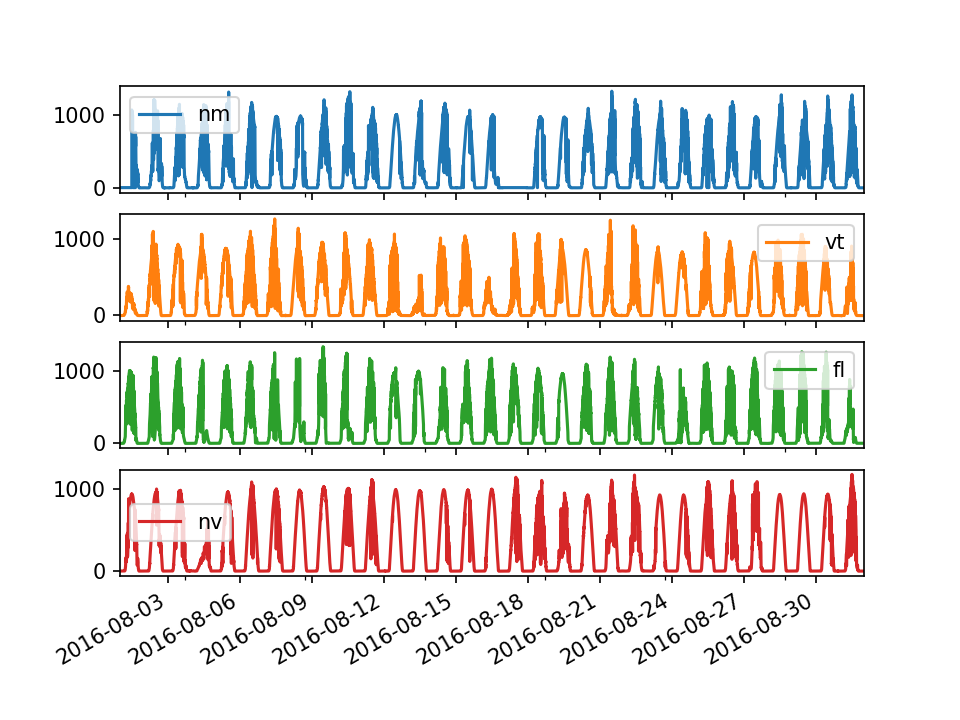

nm 11104019.5766


/Users/benellis/miniconda3/lib/python3.5/site-packages/pandas/plotting/_core.py:1682: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


vt 9420886.39934


/Users/benellis/miniconda3/lib/python3.5/site-packages/pandas/plotting/_core.py:1682: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


fl 10357392.7584
nv 12851808.7398


In [26]:
start_date = '2016-08-01'
end_date = '2016-09-01'
fig, axes = plt.subplots()
irradiances_by_site = pd.DataFrame()
irradiances_by_site['nm'] = nm_data['Global_Wm2'][(nm_data.index >= start_date) & (nm_data.index < end_date)]
irradiances_by_site['vt'] = vt_data['Global_Wm2'][(vt_data.index >= start_date) & (vt_data.index < end_date)]
irradiances_by_site['fl'] = fl_data['Global_Wm2'][(fl_data.index >= start_date) & (fl_data.index < end_date)]
irradiances_by_site['nv'] = nv_data['Global_Wm2'][(nv_data.index >= start_date) & (nv_data.index < end_date)]

from scipy.integrate import trapz
for site in irradiances_by_site:
#     print(irradiances_by_site[site].isnull().values.any())
    print(site, trapz(irradiances_by_site[site].fillna(0).values))
    irradiances_by_site.plot(subplots=True, ax=axes, sharex=True, legend=True)

In [27]:
nm_pcts = clear_sky_detection_analysis(irradiances_by_site['nm'], nm_site)

/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:658: RuntimeWarning: invalid value encountered in true_divide
  meas_slope_nstd = np.std(meas_slope, axis=0, ddof=1) / meas_mean
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:683: RuntimeWarning: invalid value encountered in less
  c4 = meas_slope_nstd < var_diff


In [28]:
vt_pcts = clear_sky_detection_analysis(irradiances_by_site['vt'], vt_site)

/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:680: RuntimeWarning: invalid value encountered in less
  c1 = np.abs(meas_mean - alpha*clear_mean) < mean_diff
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:681: RuntimeWarning: invalid value encountered in less
  c2 = np.abs(meas_max - alpha*clear_max) < max_diff
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:682: RuntimeWarning: invalid value encountered in greater
  c3 = (line_diff > lower_line_length) & (line_diff < upper_line_length)
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:682: RuntimeWarning: invalid value encountered in less
  c3 = (line_diff > lower_line_length) & (line_diff < upper_line_length)
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:683: RuntimeWarning: invalid value encountered in less
  c4 = meas_slope_nstd < var_diff
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsk

In [29]:
fl_pcts = clear_sky_detection_analysis(irradiances_by_site['fl'], fl_site)

/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:658: RuntimeWarning: invalid value encountered in true_divide
  meas_slope_nstd = np.std(meas_slope, axis=0, ddof=1) / meas_mean
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:680: RuntimeWarning: invalid value encountered in less
  c1 = np.abs(meas_mean - alpha*clear_mean) < mean_diff
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:681: RuntimeWarning: invalid value encountered in less
  c2 = np.abs(meas_max - alpha*clear_max) < max_diff
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:682: RuntimeWarning: invalid value encountered in greater
  c3 = (line_diff > lower_line_length) & (line_diff < upper_line_length)
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:682: RuntimeWarning: invalid value encountered in less
  c3 = (line_diff > lower_line_length) & (line_diff < upper_line_length)
/Users/benellis/miniconda3/l

In [30]:
nv_pcts = clear_sky_detection_analysis(irradiances_by_site['nv'], nv_site)

In [31]:
pcts = pd.DataFrame([nm_pcts, vt_pcts, fl_pcts, nv_pcts], index=['nm', 'vt', 'fl', 'nv'])

In [32]:
pcts

,mean_diff,max_diff,line_length,slope_nstd,slope_max,clear
nm,0.770384,0.773341,0.617732,0.579171,0.747037,0.165031
vt,0.747463,0.756627,0.584034,0.549663,0.688109,0.146416
fl,0.750196,0.757164,0.560731,0.556698,0.682642,0.096528
nv,0.566109,0.566803,0.664516,0.761847,0.851359,0.088374


<IPython.core.display.Javascript object>


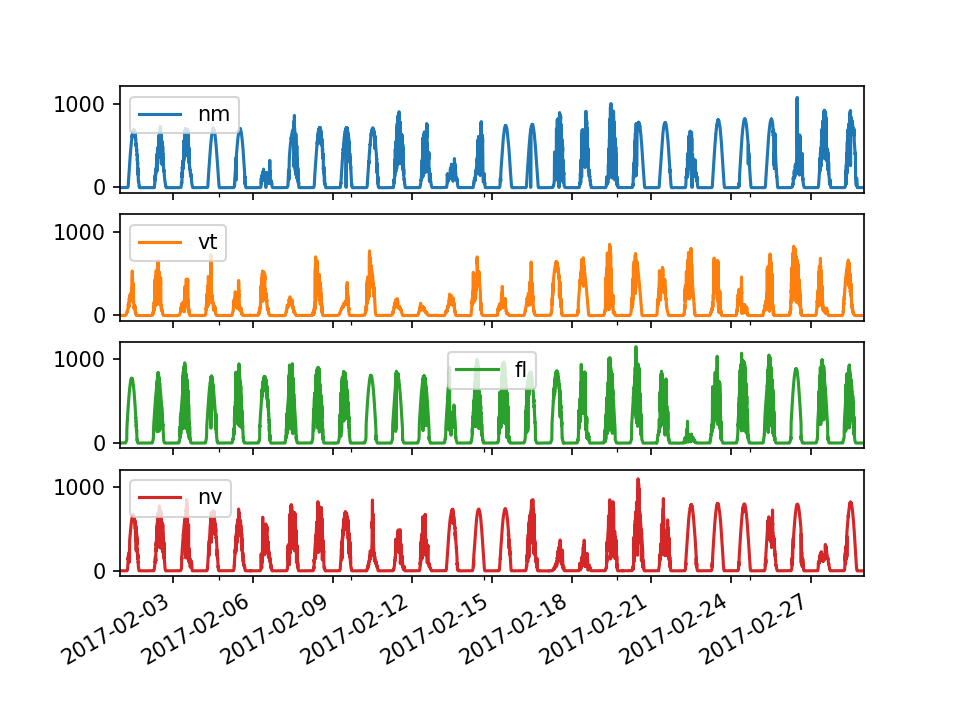

nm 6572844.73314
vt 3329422.99323
fl 7335689.52753
nv 5926504.26014


/Users/benellis/miniconda3/lib/python3.5/site-packages/pandas/plotting/_core.py:1682: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1163aa668>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x114084898>], dtype=object)

In [33]:
start_date = '2017-02-01'
end_date = '2017-03-01'
fig, axes = plt.subplots()
irradiances_by_site = pd.DataFrame()
irradiances_by_site['nm'] = nm_data['Global_Wm2'][(nm_data.index >= start_date) & (nm_data.index < end_date)]
irradiances_by_site['vt'] = vt_data['Global_Wm2'][(vt_data.index >= start_date) & (vt_data.index < end_date)]
irradiances_by_site['fl'] = fl_data['Global_Wm2'][(fl_data.index >= start_date) & (fl_data.index < end_date)]
irradiances_by_site['nv'] = nv_data['Global_Wm2'][(nv_data.index >= start_date) & (nv_data.index < end_date)]

from scipy.integrate import trapz
for site in irradiances_by_site:
#     print(irradiances_by_site[site].isnull().values.any())
    print(site, trapz(irradiances_by_site[site].fillna(0).values))


irradiances_by_site.plot(subplots=True, ax=axes, sharex=True, sharey=True, legend=True)

In [34]:
nm_pcts = clear_sky_detection_analysis(irradiances_by_site['nm'], nm_site)

/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:658: RuntimeWarning: invalid value encountered in true_divide
  meas_slope_nstd = np.std(meas_slope, axis=0, ddof=1) / meas_mean
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:683: RuntimeWarning: invalid value encountered in less
  c4 = meas_slope_nstd < var_diff


In [35]:
vt_pcts = clear_sky_detection_analysis(irradiances_by_site['vt'], vt_site)

/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:680: RuntimeWarning: invalid value encountered in less
  c1 = np.abs(meas_mean - alpha*clear_mean) < mean_diff
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:681: RuntimeWarning: invalid value encountered in less
  c2 = np.abs(meas_max - alpha*clear_max) < max_diff
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:682: RuntimeWarning: invalid value encountered in greater
  c3 = (line_diff > lower_line_length) & (line_diff < upper_line_length)
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:682: RuntimeWarning: invalid value encountered in less
  c3 = (line_diff > lower_line_length) & (line_diff < upper_line_length)
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:683: RuntimeWarning: invalid value encountered in less
  c4 = meas_slope_nstd < var_diff
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsk

In [36]:
fl_pcts = clear_sky_detection_analysis(irradiances_by_site['fl'], fl_site)

/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:680: RuntimeWarning: invalid value encountered in less
  c1 = np.abs(meas_mean - alpha*clear_mean) < mean_diff
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:681: RuntimeWarning: invalid value encountered in less
  c2 = np.abs(meas_max - alpha*clear_max) < max_diff
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:682: RuntimeWarning: invalid value encountered in greater
  c3 = (line_diff > lower_line_length) & (line_diff < upper_line_length)
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:682: RuntimeWarning: invalid value encountered in less
  c3 = (line_diff > lower_line_length) & (line_diff < upper_line_length)
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:683: RuntimeWarning: invalid value encountered in less
  c4 = meas_slope_nstd < var_diff
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsk

In [37]:
nv_pcts = clear_sky_detection_analysis(irradiances_by_site['nv'], nv_site)

In [38]:
pcts = pd.DataFrame([nm_pcts, vt_pcts, fl_pcts, nv_pcts], index=['nm', 'vt', 'fl', 'nv'])

In [39]:
pcts

,mean_diff,max_diff,line_length,slope_nstd,slope_max,clear
nm,0.841433,0.855300,0.732877,0.694376,0.809332,0.171949
vt,0.725211,0.733571,0.676242,0.611148,0.808687,0.049851
fl,0.840019,0.858922,0.675176,0.660415,0.762124,0.140228
nv,0.636526,0.634318,0.638436,0.664012,0.794820,0.042535


# Outlook

It's hard to say exaclty how different locations are affected by default settings of the PVLib clear sky detections.  Different locations get different weather, which will affect the irradiance measures, which in turn affects what is detected as clear sky.  It might be best to try to find blocks times with similar total irradiance. 